<a href="https://colab.research.google.com/github/matiahasmasan/TSP---berlin52/blob/main/tema4b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
!pip install -q gdown

!gdown "https://drive.google.com/uc?id=1xBhcsoJsQT3Lgk65UzgcprBlLmfxyyQz"
# !gdown --folder "https://drive.google.com/drive/folders/1RJCYu6hMsa3xOHn1-jZWsq4o0N10Pvt8"


Downloading...
From: https://drive.google.com/uc?id=1xBhcsoJsQT3Lgk65UzgcprBlLmfxyyQz
To: /content/canada_polling_data.csv
100% 17.5k/17.5k [00:00<00:00, 45.3MB/s]


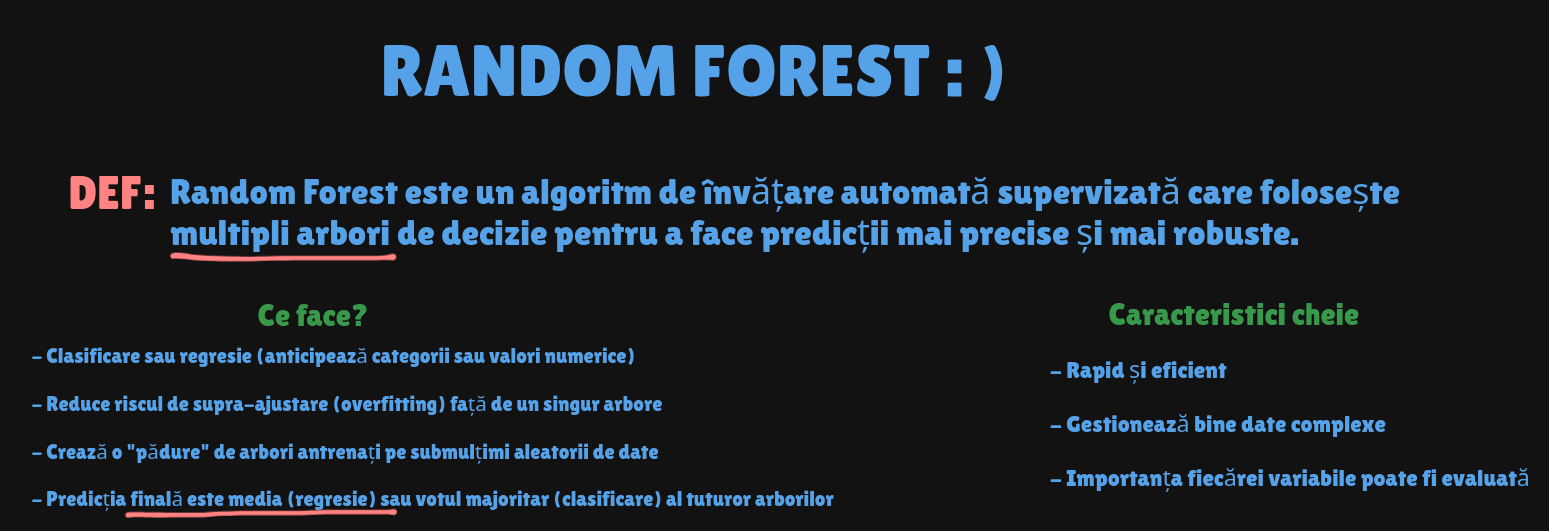

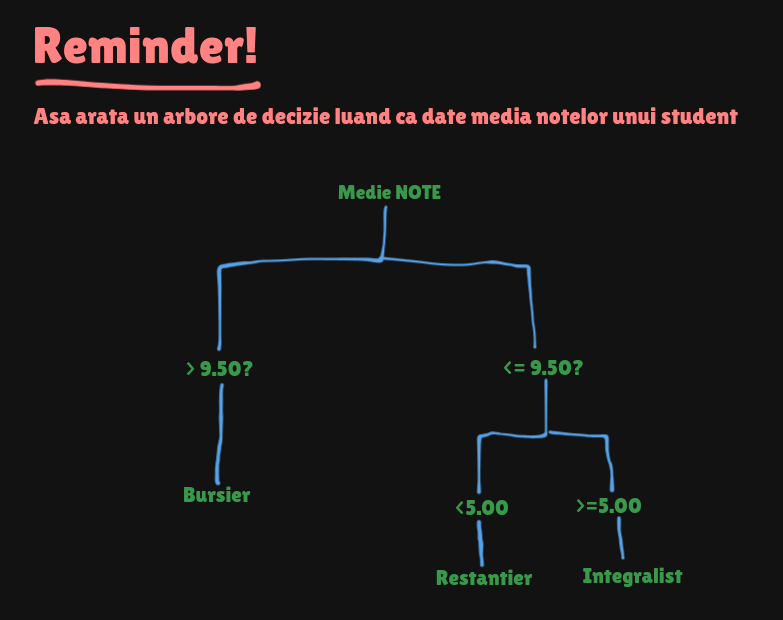

In [26]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import TimeSeriesSplit

warnings.filterwarnings('ignore')

In prima faza importam librariile necesare.

In [27]:
data = pd.read_csv('canada_polling_data.csv')

Incarcam datele din csv-ul ```canada_polling_data```

In [28]:
data.head()

,Last date of polling,CPC,LPC,NDP,BQ,PPC,GPC,Others
0,"March 23, 2025",38.0,44.0,6,5,3,3,1
1,"March 23, 2025",36.0,40.0,9,6,3,4,2
2,"March 23, 2025",38.0,44.0,7,6,3,1,1
3,"March 22, 2025",37.8,42.3,8.4,7.0,2.1,2.2,0.4
4,"March 22, 2025",37.0,39.0,9,6,3,4,2


După o mică analiză asupra datelor putem observa 2 lucruri:

1. **Tipul datelor**:
   - `Last date of polling` → Data la care s-a realizat sondajul [în forma `Month day, year`].
   - Și 7 coloane cu numele partidelor → reprezentând valoarea numerică înregistrată la data indicată de prima coloană.
     - Partidele sunt următoarele: `CPC`, `LPC`, `NDP`, `BQ`, `PPC`, `GPC` și `OTHERS`.

2. **Coloana `Others`** practic nu ne interesează întrucât sunt valori minoritare... (de altfel, lucrul ăsta e valabil și pentru restul partidelor care nu sunt `CPC` și `LPC`).

In [29]:
data = data.drop(columns=['Others'])
data['Last date of polling'] = pd.to_datetime(data['Last date of polling'], format='%B %d, %Y', errors='coerce').dt.strftime('%Y-%m-%d')
data

,Last date of polling,CPC,LPC,NDP,BQ,PPC,GPC
0,2025-03-23,38.0,44.0,6,5,3,3
1,2025-03-23,36.0,40.0,9,6,3,4
2,2025-03-23,38.0,44.0,7,6,3,1
3,2025-03-22,37.8,42.3,8.4,7.0,2.1,2.2
4,2025-03-22,37.0,39.0,9,6,3,4
...,...,...,...,...,...,...,...
419,2021-10-29,30.1,30.8,21.6,7.4,5.8,3.1
420,2021-10-24,33.3,33.8,15.4,5.5,—,3.0
421,2021-10-22,30.8,29.9,23.1,7.3,5.3,2.7
422,2021-10-20,30.0,33.0,19,7,6,3


Coloana `Others` o să fie eliminată din setul de date și `Last date of polling` o să fie prelucrată pentru a fi sub forma `year-month-day` pentru diagramă.

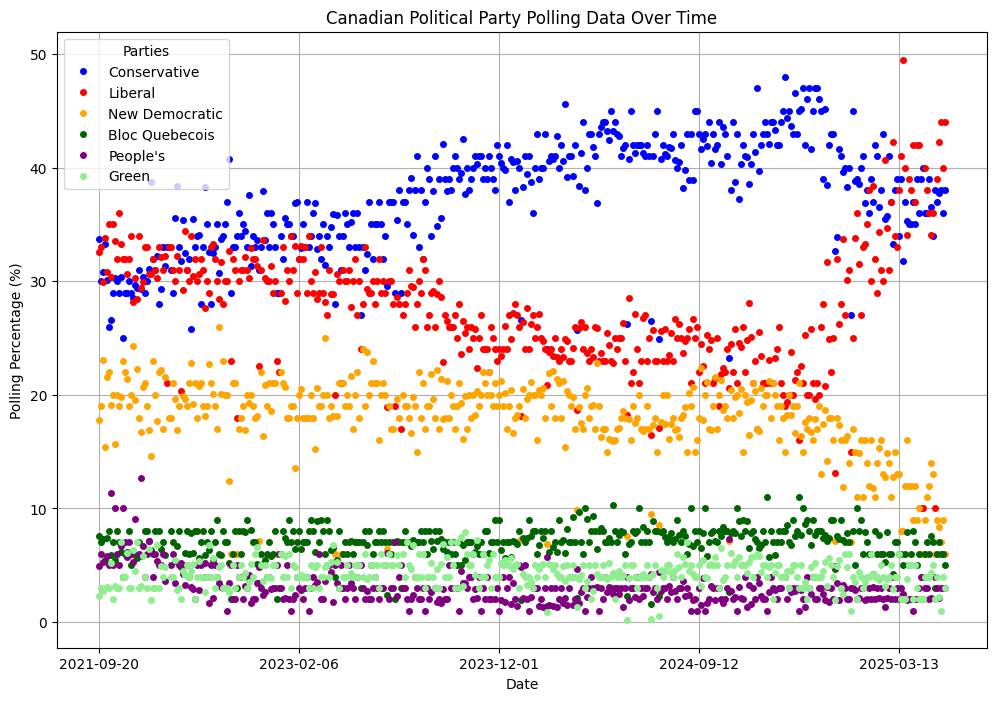

In [30]:
party_columns = ['CPC', 'LPC', 'NDP', 'BQ', 'PPC', 'GPC']
for col in party_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

data.set_index('Last date of polling', inplace=True)

colors = {
    "CPC": "blue",
    "LPC": "red",
    "NDP": "orange",
    "BQ": "darkgreen",
    "GPC": "lightgreen",
    "PPC": "purple",
}

labels = {
    "CPC": "Conservative",
    "LPC": "Liberal",
    "NDP": "New Democratic",
    "BQ": "Bloc Quebecois",
    "GPC": "Green",
    "PPC": "People's",
}

data = data.sort_index()

ax = data[party_columns].plot(figsize=(12, 8), marker='o', linestyle='', markersize=4, color=[colors[col] for col in party_columns])
ax.set_title('Canadian Political Party Polling Data Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Polling Percentage (%)')
ax.legend([labels[col] for col in party_columns], title='Parties')
plt.grid(True)
plt.show()

In [31]:
data['Winner'] = data[party_columns].idxmax(axis=1)
data['Winner_Percentage'] = data[party_columns].max(axis=1)
data[['Winner', 'Winner_Percentage']]

,Winner,Winner_Percentage
Last date of polling,,
2021-09-20,CPC,33.7
2021-10-20,LPC,33.0
2021-10-22,CPC,30.8
2021-10-24,LPC,33.8
2021-10-29,LPC,30.8
...,...,...
2025-03-22,LPC,39.0
2025-03-22,LPC,42.3
2025-03-23,LPC,44.0


Reducție de date întrucât ne interesează doar învingătorul din cadrul datelor.

Tipul acesta de set de date are o denumire specifică... date de tip `time series` (serii temporale).

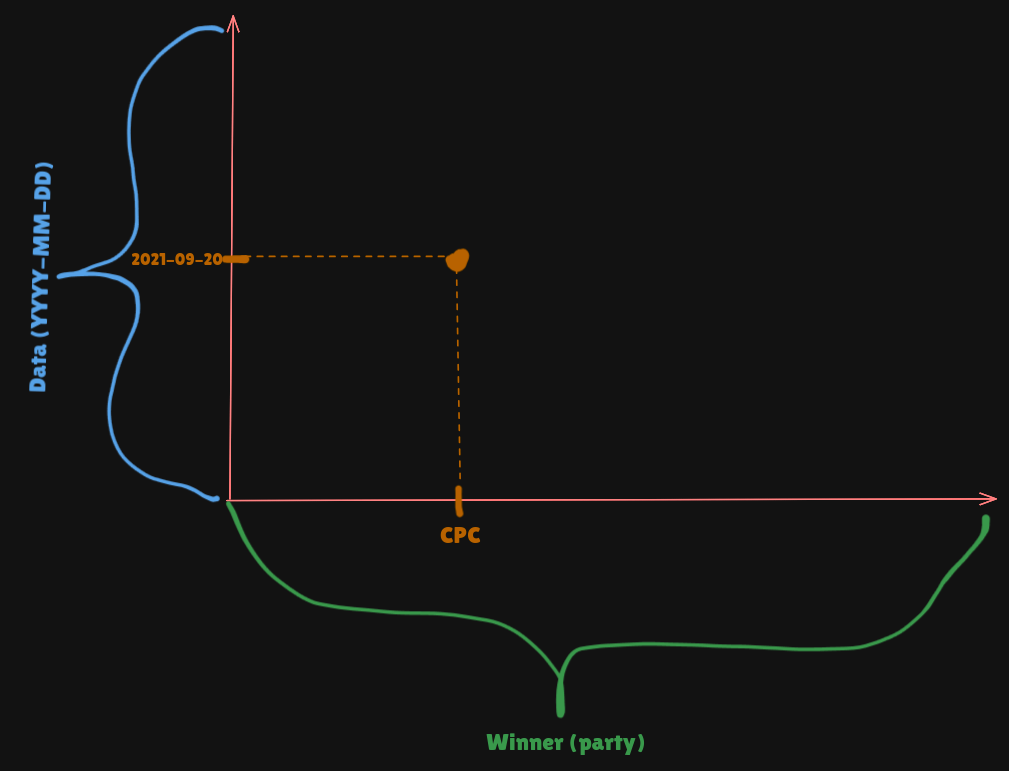

In [32]:
X = data[party_columns].copy()
y_winner = data['Winner'].copy()
y_percentage = data['Winner_Percentage'].copy()
X = X.fillna(X.mean())

In [33]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train_winner, y_test_winner = train_test_split(X, y_winner, test_size=0.2, random_state=42)
# X_train_perc, X_test_perc, y_train_perc, y_test_perc = train_test_split(X, y_percentage, test_size=0.2, random_state=42)

**ATENȚIE!**

Să ne amintim ce face metoda `train_test_split` → împarte setul de date aleator în testare și antrenare... dacă folosim metoda asta putem, foarte ușor, ajunge la cazuri în care modelul o să folosească date din viitor să prezică datele din trecut... ceea ce reprezintă un non-sens!

In [34]:
# split_index = int(len(X) * 0.95)

# X_train = X.iloc[:split_index]
# X_test = X.iloc[split_index:]
# y_train_winner = y_winner.iloc[:split_index]
# y_test_winner = y_winner.iloc[split_index:]
# y_train_perc = y_percentage.iloc[:split_index]
# y_test_perc = y_percentage.iloc[split_index:]

Metoda de împărțit de mai sus este okay-ish, însă nu ține cont de dependențe temporale și poate duce la `data leakage` dacă trend-ul se schimbă brusc.

In [35]:
tscv_final = TimeSeriesSplit(n_splits=20)
train_index, test_index = list(tscv_final.split(X))[-1]

X_train = X.iloc[train_index]
X_test = X.iloc[test_index]
y_train_winner = y_winner.iloc[train_index]
y_test_winner = y_winner.iloc[test_index]
y_train_perc = y_percentage.iloc[train_index]
y_test_perc = y_percentage.iloc[test_index]

Împărțim setul de date în 80% antrenare și 20% testare... în mod normal... însă în cazul de față trend-ul se schimbă exact în partea de 20%....

Folosind `TimeSeriesSplit` în cazul acesta creează mai multe split-uri de antrenare/test care păstrează ordinea temporală: fiecare split folosește o cantitate crescândă de date istorice pentru antrenare și următorul segment cronologic pentru testare.. iar tehnica asta previne data leakage-urile.

In [36]:
rf_model = RandomForestClassifier(n_estimators=20000, random_state=42, bootstrap=True, max_depth=20, min_samples_split=10)
rf_model.fit(X_train, y_train_winner)

RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=20000,
                       random_state=42)

In [37]:
rf_regressor = RandomForestRegressor(n_estimators=1000, random_state=42, bootstrap=True)
rf_regressor.fit(X_train, y_train_perc)

RandomForestRegressor(n_estimators=1000, random_state=42)

Din documentația oficială [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html.).

**Cei mai importanți parametri pe care `RandomForestClassifier` îi poate prelua sunt următorii:**

1. **`n_estimators`** → Numărul de arbori în pădure (implicit 100.. valori mai mari reduc overfitting-ul, dar cresc timpul de antrenare).
2. **`max_depth`** → Adâncimea maximă a arborilor (implicit None.. limitează complexitatea pentru a evita overfitting-ul).
3. **`min_samples_split`** → Numărul minim de eșantioane pentru a împărți un nod (implicit 2.. valori mai mari reduc overfitting-ul).
4. **`min_samples_leaf`** → Numărul minim de eșantioane într-un nod frunză (implicit 1.. valori mai mari reduc overfitting-ul).

In [38]:
y_pred_winner = rf_model.predict(X_test)

In [39]:
accuracy = accuracy_score(y_test_winner, y_pred_winner)
print(f"Model Accuracy for Winner: {accuracy:.4f}")
print("\nClassification Report for Winner:")
print(classification_report(y_test_winner, y_pred_winner, digits=4))


Model Accuracy for Winner: 0.9000

Classification Report for Winner:
              precision    recall  f1-score   support

         CPC     0.7500    1.0000    0.8571         6
         LPC     1.0000    0.8571    0.9231        14

    accuracy                         0.9000        20
   macro avg     0.8750    0.9286    0.8901        20
weighted avg     0.9250    0.9000    0.9033        20



In [40]:
y_pred_perc = rf_regressor.predict(X_test)
mse = mean_squared_error(y_test_perc, y_pred_perc)
r2 = r2_score(y_test_perc, y_pred_perc)
print(f"\nRegressor MSE for Winner_Percentage: {mse:.4f}")
print(f"Regressor R² for Winner_Percentage: {r2:.4f}")



Regressor MSE for Winner_Percentage: 3.9757
Regressor R² for Winner_Percentage: 0.3411


Se observă că Random Forest Regressor nu e minunat în a capta trenduri, pe bază de MSE și R².

Pentru a capta cu adevărat trendul și valorile pentru benchmark(MSE și R²) putem să facem următoarele lucruri:

1. **Feature Engineering**: adăugăm lag features, rolling statistics și dinamici inter-party (Random Forest nu este ```"time-aware"```!)

sau

2. **Folosim un algoritm statistic specializat pe serii temporale**: ARIMA, SARIMA, SARIMAX, FB PROPHET

In [41]:
feature_importance = pd.DataFrame({
    'Party': party_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)


Feature Importance:
  Party  Importance
1   LPC    0.426679
0   CPC    0.264137
4   PPC    0.121308
2   NDP    0.089987
3    BQ    0.060483
5   GPC    0.037406


In [42]:
latest_polling = X.iloc[-1:].values

predicted_winner = rf_model.predict(latest_polling)[0]
predicted_winner_percentage = rf_regressor.predict(latest_polling)[0]

print(f"\nPredicted Election Winner: {predicted_winner}")
print(f"Predicted Winner Percentage: {predicted_winner_percentage:.2f}%")

predicted_probabilities = rf_model.predict_proba(latest_polling)[0]
print("\nPredicted Probabilities for Winner:")
for party, prob in zip(party_columns, predicted_probabilities):
    print(f"{party}: {prob:.4f}")



Predicted Election Winner: LPC
Predicted Winner Percentage: 38.47%

Predicted Probabilities for Winner:
CPC: 0.3036
LPC: 0.6964


### Observație

După cum se poate vedea după data de 2025-01-13 ceva s-a întâmplat întrucât partidul LPC, care a fost pe un trend descendent clar, timp de 3 ani, brusc, a avut parte de o revitalizare.

**Ce s-a întâmplat?**  
O multitudine de evenimente, dar pentru acest exemplu o să le luăm ca unul... acest factor extern în statistică se numește shock event sau eveniment exogen.

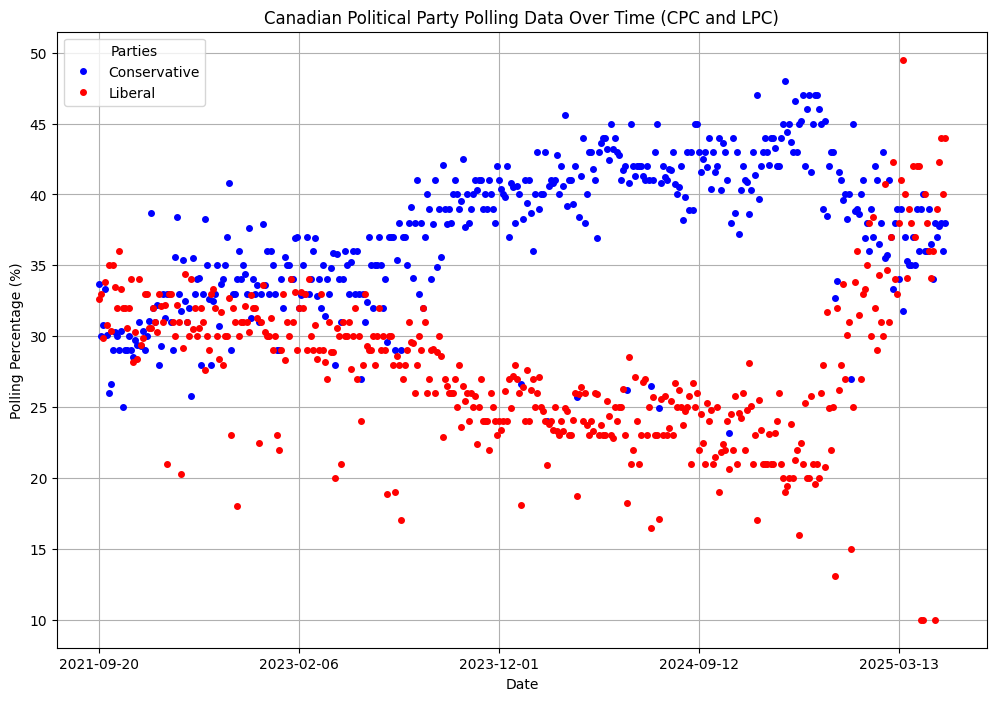

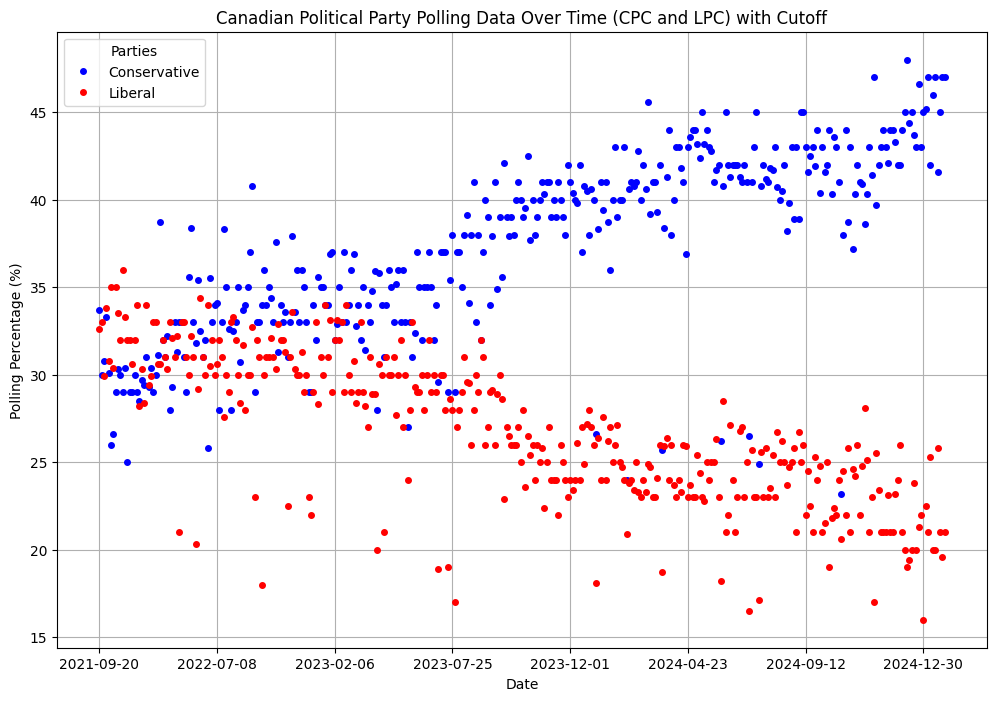

In [43]:
selected_parties = ['CPC', 'LPC']
ax = data[selected_parties].plot(figsize=(12, 8), marker='o', linestyle='', markersize=4, color=[colors[col] for col in selected_parties])
ax.set_title('Canadian Political Party Polling Data Over Time (CPC and LPC)')
ax.set_xlabel('Date')
ax.set_ylabel('Polling Percentage (%)')
ax.legend([labels[col] for col in selected_parties], title='Parties')
plt.grid(True)
plt.show()

data_temp = data[data.index <= '2025-01-13']

ax = data_temp[selected_parties].plot(figsize=(12, 8), marker='o', linestyle='', markersize=4, color=[colors[col] for col in selected_parties])
ax.set_title('Canadian Political Party Polling Data Over Time (CPC and LPC) with Cutoff')
ax.set_xlabel('Date')
ax.set_ylabel('Polling Percentage (%)')
ax.legend([labels[col] for col in selected_parties] + ['Shock Event Cutoff'], title='Parties')
plt.grid(True)
plt.show()

### Tema

Antrenați un model de regresie și clasificare random forest pentru datele dinaintea datei 2025-01-13 și comparați rezultatele obținute cu cele reale!

In [44]:
data_before_cutoff = data[data.index < '2025-01-13']
data_before_cutoff.head()

,CPC,LPC,NDP,BQ,PPC,GPC,Winner,Winner_Percentage
Last date of polling,,,,,,,,
2021-09-20,33.7,32.6,17.8,7.6,4.9,2.3,CPC,33.7
2021-10-20,30.0,33.0,19.0,7.0,6.0,3.0,LPC,33.0
2021-10-22,30.8,29.9,23.1,7.3,5.3,2.7,CPC,30.8
2021-10-24,33.3,33.8,15.4,5.5,NaN,3.0,LPC,33.8
2021-10-29,30.1,30.8,21.6,7.4,5.8,3.1,LPC,30.8


In [45]:
X_before_cutoff = data_before_cutoff[party_columns].copy()
y_winner_before_cutoff = data_before_cutoff['Winner'].copy()
y_percentage_before_cutoff = data_before_cutoff['Winner_Percentage'].copy()
X_before_cutoff = X_before_cutoff.fillna(X_before_cutoff.mean())

print("X_before_cutoff head:")
print(X_before_cutoff.head())
print("\ny_winner_before_cutoff head:")
print(y_winner_before_cutoff.head())
print("\ny_percentage_before_cutoff head:")
print(y_percentage_before_cutoff.head())

X_before_cutoff head:
                       CPC   LPC   NDP   BQ       PPC  GPC
Last date of polling                                      
2021-09-20            33.7  32.6  17.8  7.6  4.900000  2.3
2021-10-20            30.0  33.0  19.0  7.0  6.000000  3.0
2021-10-22            30.8  29.9  23.1  7.3  5.300000  2.7
2021-10-24            33.3  33.8  15.4  5.5  3.256286  3.0
2021-10-29            30.1  30.8  21.6  7.4  5.800000  3.1

y_winner_before_cutoff head:
Last date of polling
2021-09-20    CPC
2021-10-20    LPC
2021-10-22    CPC
2021-10-24    LPC
2021-10-29    LPC
Name: Winner, dtype: object

y_percentage_before_cutoff head:
Last date of polling
2021-09-20    33.7
2021-10-20    33.0
2021-10-22    30.8
2021-10-24    33.8
2021-10-29    30.8
Name: Winner_Percentage, dtype: float64


In [47]:
tscv_before_cutoff = TimeSeriesSplit(n_splits=20)
train_index_before_cutoff, test_index_before_cutoff = list(tscv_before_cutoff.split(X_before_cutoff))[-1]

X_train_before_cutoff = X_before_cutoff.iloc[train_index_before_cutoff]
X_test_before_cutoff = X_before_cutoff.iloc[test_index_before_cutoff]
y_train_winner_before_cutoff = y_winner_before_cutoff.iloc[train_index_before_cutoff]
y_test_winner_before_cutoff = y_winner_before_cutoff.iloc[test_index_before_cutoff]
y_train_perc_before_cutoff = y_percentage_before_cutoff.iloc[train_index_before_cutoff]
y_test_perc_before_cutoff = y_percentage_before_cutoff.iloc[test_index_before_cutoff]

print("X_train_before_cutoff shape:", X_train_before_cutoff.shape)
print("X_test_before_cutoff shape:", X_test_before_cutoff.shape)

X_train_before_cutoff shape: (342, 6)
X_test_before_cutoff shape: (17, 6)


In [49]:
rf_model_before_cutoff = RandomForestClassifier(n_estimators=20000, random_state=42, bootstrap=True, max_depth=20, min_samples_split=10)
rf_model_before_cutoff.fit(X_train_before_cutoff, y_train_winner_before_cutoff)


RandomForestClassifier(max_depth=20, min_samples_split=10, n_estimators=20000,
                       random_state=42)

In [50]:
rf_regressor_before_cutoff = RandomForestRegressor(n_estimators=1000, random_state=42, bootstrap=True)
rf_regressor_before_cutoff.fit(X_train_before_cutoff, y_train_perc_before_cutoff)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [51]:
y_pred_winner_before_cutoff = rf_model_before_cutoff.predict(X_test_before_cutoff)
accuracy_before_cutoff = accuracy_score(y_test_winner_before_cutoff, y_pred_winner_before_cutoff)
print(f"Model Accuracy for Winner (before cutoff): {accuracy_before_cutoff:.4f}")
print("\nClassification Report for Winner (before cutoff):")
print(classification_report(y_test_winner_before_cutoff, y_pred_winner_before_cutoff, digits=4))

Model Accuracy for Winner (before cutoff): 1.0000

Classification Report for Winner (before cutoff):
              precision    recall  f1-score   support

         CPC     1.0000    1.0000    1.0000        17

    accuracy                         1.0000        17
   macro avg     1.0000    1.0000    1.0000        17
weighted avg     1.0000    1.0000    1.0000        17



In [53]:
y_pred_perc_before_cutoff = rf_regressor_before_cutoff.predict(X_test_before_cutoff)
mse_before_cutoff = mean_squared_error(y_test_perc_before_cutoff, y_pred_perc_before_cutoff)
r2_before_cutoff = r2_score(y_test_perc_before_cutoff, y_pred_perc_before_cutoff)
print(f"\nRegressor MSE for Winner_Percentage (before cutoff): {mse_before_cutoff:.4f}")
print(f"Regressor R² for Winner_Percentage (before cutoff): {r2_before_cutoff:.4f}")


Regressor MSE for Winner_Percentage (before cutoff): 0.7636
Regressor R² for Winner_Percentage (before cutoff): 0.7648
